In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Module, Linear, Sequential, Softplus, Softsign
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature

molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
train_ec

,molA,molB,xe,Te
195,CaBr,GaBr3,20,95.0
3085,KF,TaF5,71,697.0
1859,CeCl3,NaCl,32.5,488.0
3464,KF,ZrF4,80,766.0
3770,KF,ThF4,44,875.0
...,...,...,...,...
1552,HfF4,KF,57,420.0
546,CsNO3,NaCNS,31,184.0
1948,CsCl,CsReO4,38,500.0
3815,NaF,Na2SiO3,59,896.0


In [7]:
val_ec

,molA,molB,xe,Te
3387,K2SO4,MgSO4,64.5,750.0
3597,KBO2,K2WO4,67,808.0
4062,K2O,Nb2O5,33.1,1150.0
2671,ThCl4,UCl3,70,632.0
3198,CaCl2,Ca3N2,87,712.0
...,...,...,...,...
1330,CdBr2,ZnBr2,21.2,364.0
2721,SrNb2O6,SrV2O6,8,640.0
4435,Gd2O3,ZrO2,86,2175.0
118,BeCl2,GaCl3,5.7,64.5


In [8]:
test_ec

,molA,molB,xe,Te
3,BCl3,PCl3,94,-110.0
16,NH3,NH4NO3,96,-79.5
19,POCl3,SiCl4,4,-71.8
56,POCl3,TiCl4,3,-0.6
78,FeCl3,ReOCl4,0,29.0
...,...,...,...,...
4376,Al2O3,MgO,35,2000.0
4397,MgO,Y2O3,48,2060.0
4426,BeO,PuO2,66,2135.0
4454,SrO,ZrO2,25,2300.0


In [9]:
print(molecule_features.columns)
print(eutectic_compilation.columns)

Index(['mol', 'molecular_weight', 'complexity', 'rotatable_bond_count',
       'heavy_atom_count', 'topological_area'],
      dtype='object')
Index(['molA', 'molB', 'xe', 'Te'], dtype='object')


In [10]:
print(molecule_features.dtypes)
print(eutectic_compilation.dtypes)

mol                      object
molecular_weight        float64
complexity              float64
rotatable_bond_count    float64
heavy_atom_count        float64
topological_area        float64
dtype: object
molA     object
molB     object
xe       object
Te      float64
dtype: object


In [11]:
molecule_features.iloc[0]

mol                        BaO
molecular_weight        153.33
complexity                 2.0
rotatable_bond_count       0.0
heavy_atom_count           2.0
topological_area          17.1
Name: 0, dtype: object

In [12]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [13]:
# SNN class with model
class SiameseNeuralNetwork(Module):
    def __init__(self, start_features):
        super(SiameseNeuralNetwork, self).__init__()
        
        self.fc = Linear(in_features=5, out_features=1, bias=False) # final stage where prediction is made
        
        self.model = Sequential(
            Linear(in_features=start_features, out_features=20, bias=False),
            Softplus(),
            Linear(in_features=20, out_features=15, bias=False),
            Softplus(),
            Linear(in_features=15, out_features=5, bias=False), # create the feature vectors
            Softplus()
        )

    def forward(self, x1, x2):                
        y1 = self.model(x1)
        
        # implementing f(A,B) = 1 - f(B,A)
        with torch.no_grad():
            self.model[4].weight = torch.nn.Parameter(-1 * self.model[4].weight) # negate the weights
                    
        y2 = self.model(x2)   
        
        with torch.no_grad():
            self.model[4].weight = torch.nn.Parameter(-1 * self.model[4].weight) # restore weights
        
        d = y1 - y2                      # difference for xe
        # d = torch.abs(y1 - y2)           # difference for Te
        p = torch.sigmoid(self.fc(d))
        return p

In [14]:
class MakeDataset(Dataset):
    def __init__(self, ec_df, mf_df, num_features):
        self.ecdf = ec_df
        self.mfdf = mf_df
        self.nf = num_features

    def __len__(self):
        return len(self.ecdf)
  
    def __getitem__(self, idx):
        ec = self.ecdf.iloc[idx]
        
        m1f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[0]])[0][1:self.nf+1].astype(float))
        m2f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[1]])[0][1:self.nf+1].astype(float))
        xe = torch.tensor(float(ec[2]))
        Te = torch.tensor(ec[3])
        
        return m1f, m2f, xe, Te

In [15]:
# define parameters for training
starting_features = 5
batchsize = 20
train_dset = MakeDataset(train_ec, molecule_features, starting_features)
val_dset = MakeDataset(val_ec, molecule_features, starting_features)
test_dset = MakeDataset(test_ec, molecule_features, starting_features)

Epoch 1 | Train Loss: 31.869 | Train Baseline: 11.498 | Val Loss: 3.656 | Val Baseline: 1.287
Epoch 2 | Train Loss: 31.427 | Train Baseline: 11.485 | Val Loss: 3.595 | Val Baseline: 1.283
Epoch 3 | Train Loss: 31.137 | Train Baseline: 11.53 | Val Loss: 3.55 | Val Baseline: 1.283
Epoch 4 | Train Loss: 30.651 | Train Baseline: 11.421 | Val Loss: 3.5 | Val Baseline: 1.285
Epoch 5 | Train Loss: 30.267 | Train Baseline: 11.509 | Val Loss: 3.445 | Val Baseline: 1.284
Epoch 6 | Train Loss: 29.498 | Train Baseline: 11.449 | Val Loss: 3.391 | Val Baseline: 1.287
Epoch 7 | Train Loss: 28.997 | Train Baseline: 11.481 | Val Loss: 3.323 | Val Baseline: 1.287
Epoch 8 | Train Loss: 28.541 | Train Baseline: 11.475 | Val Loss: 3.264 | Val Baseline: 1.285
Epoch 9 | Train Loss: 27.744 | Train Baseline: 11.447 | Val Loss: 3.204 | Val Baseline: 1.287
Epoch 10 | Train Loss: 27.161 | Train Baseline: 11.506 | Val Loss: 3.125 | Val Baseline: 1.286
Epoch 11 | Train Loss: 26.535 | Train Baseline: 11.491 | Val Lo

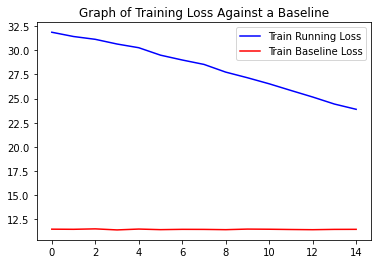

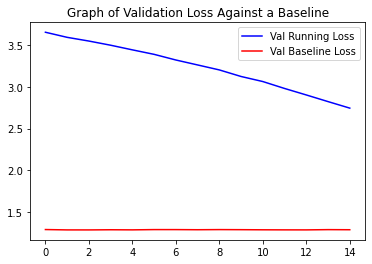

Test Loss: 0.935 | Test Baseline: 0.502



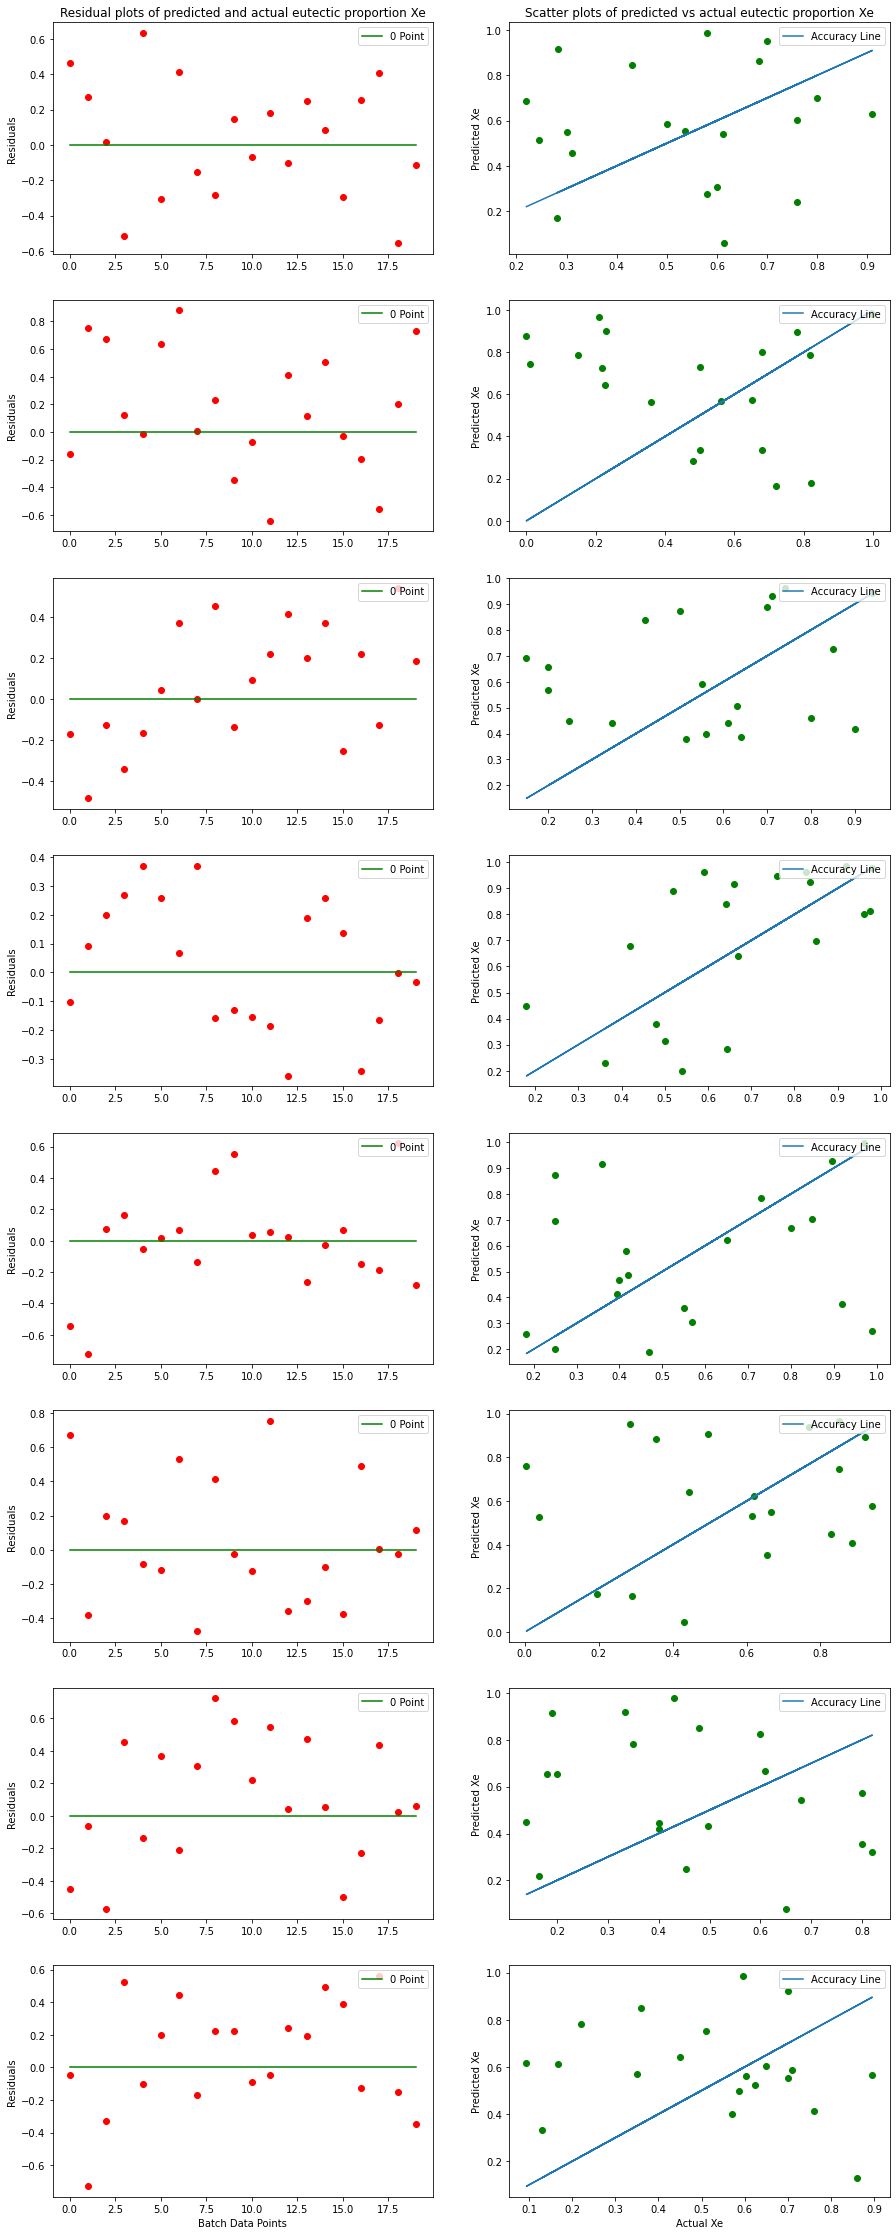

In [21]:
train_ec_dl = DataLoader(train_dset, shuffle=True, batch_size=batchsize)
val_ec_dl = DataLoader(val_dset, shuffle=True, batch_size=batchsize)
test_ec_dl = DataLoader(test_dset, shuffle=True, batch_size=batchsize)

# Set the model and training parameters
model = SiameseNeuralNetwork(starting_features)
num_epochs = 15
learn_rate = 4.15e-6

# Set optimizer and loss function. Using MSE for regression.
opt = torch.optim.Adam(model.parameters(), lr=learn_rate)
criterion = torch.nn.MSELoss()

# Set the baselines for training, validation, and testing
train_base_xe = torch.mean(torch.tensor(np.array(train_ec["xe"]).astype(float)) / 100.0)
val_base_xe = torch.mean(torch.tensor(np.array(val_ec["xe"]).astype(float)) / 100.0)
test_base_xe = torch.mean(torch.tensor(np.array(test_ec["xe"]).astype(float)) / 100.0)

###################################### Training ######################################
trloss = np.array([])
trbase = np.array([])
vloss = np.array([])
vbase = np.array([])
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_base_loss = 0.0
    val_running_loss = 0.0
    val_base_loss = 0.0

    # training step: iterate through the batch and obtain the 4 data
    for x, (m1, m2, xe, Te) in enumerate(train_ec_dl):   
        opt.zero_grad()
        xe = xe/100.0
        
        # pass 2 sets of inputs into the snn and get p, the output
        output = model(m1.float(), m2.float())           # f(A,B)
        invout = model(m2.float(), m1.float())           # f(B,A)
        
        loss = criterion(output[:, 0], xe)
        
        base = torch.full((len(xe),), train_base_xe)     # create same value array
        base_loss = criterion(base, xe)                  # obtain baseline loss

        loss.backward()
        opt.step()

        train_running_loss += loss.item()
        train_base_loss += base_loss.item()
    
    model.eval()
    for v, (m1, m2, xe, Te) in enumerate(val_ec_dl):
        xe = xe/100.0
        
        output = model(m1.float(), m2.float())
        invout = model(m2.float(), m1.float())
        val_running_loss += criterion(output[:, 0], xe).item()
        
        base = torch.full((len(xe), ), val_base_xe)
        val_base_loss += criterion(base, xe).item()
        

    print('Epoch {} | Train Loss: {} | Train Baseline: {} | Val Loss: {} | Val Baseline: {}'.format(
        epoch+1, 
        np.round(train_running_loss, 3), 
        np.round(train_base_loss, 3), 
        np.round(val_running_loss, 3), 
        np.round(val_base_loss, 3)))
    
    trloss = np.append(trloss, train_running_loss)
    trbase = np.append(trbase, train_base_loss)
    vloss = np.append(vloss, val_running_loss)
    vbase = np.append(vbase, val_base_loss)

x = np.arange(num_epochs)
plt.figure(1)
plt.plot(x, trloss, label="Train Running Loss", c="blue")
plt.plot(x, trbase, label="Train Baseline Loss", c="red")
plt.title("Graph of Training Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

plt.figure(2)
plt.plot(x, vloss, label="Val Running Loss", c="blue")
plt.plot(x, vbase, label="Val Baseline Loss", c="red")
plt.title("Graph of Validation Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

###################################### Testing and Plotting ###################################### 
test_loss = 0.0
test_baseline = 0.0
model.eval()

fig, axes = plt.subplots(8, 2)
fig.set_figheight(40)
fig.set_figwidth(15)
row = 0
col = 0

with torch.no_grad():
    for (m1, m2, xe, Te) in test_ec_dl:
        xe = xe/100.0

        outputs = model(m1.float(), m2.float())
        invouts = model(m2.float(), m1.float())

        test_loss += criterion(outputs[:, 0], xe).item()

        base = torch.full((len(xe),), test_base_xe)
        test_baseline += criterion(base, xe).item()

        x = np.arange(len(xe))

        axes[row, col].scatter(x, outputs.detach().numpy() - xe[np.newaxis].numpy().T, c="red")
        axes[row, col].plot(x, np.zeros((len(xe.numpy()),)), c="green", label="0 Point")
        axes[row, 0].set(ylabel="Residuals")
        axes[row, col].legend(loc="upper right")

        axes[row, col+1].scatter(xe.numpy(), outputs.detach().numpy(), c="green")
        axes[row, col+1].plot(xe.numpy(), xe.numpy(), label="Accuracy Line")
        axes[row, 1].set(ylabel="Predicted Xe")
        axes[row, col+1].legend(loc="upper right")

        row += 1
        if row == 8:
            break

    print('Test Loss: {} | Test Baseline: {}\n'.format(
        np.round(test_loss, 3), 
        np.round(test_baseline, 3)))

    axes[-1, 0].set(xlabel="Batch Data Points")
    axes[-1, 1].set(xlabel="Actual Xe")
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
    plt.show()

    # fig.savefig('D:\\Research\\UConn_ML\\Images\\snn_results_plots.png')

In [22]:
# should all be 1 or close to 1 to show that f(A,B) = 1 - f(B,A)
print("f(A,B): \n", outputs.flatten())
print("\n")
print("f(B,A): \n", invouts.flatten())
print("\n")
l = min(len(outputs), len(invouts))
print("f(A,B) + f(B,A): \n", outputs[0:l].flatten() + invouts[0:l].flatten())
print("\n")
print("Original Values: \n", xe)
print("\n")
print("Predicted Values: \n", outputs.flatten())

f(A,B): 
 tensor([0.6024, 0.1299, 0.5670, 0.6170, 0.5236, 0.3307, 0.6147, 0.4013, 0.9219,
        0.5708, 0.4985, 0.5597, 0.7539, 0.6439, 0.8517, 0.9859, 0.5860, 0.7812,
        0.5513, 0.4138])


f(B,A): 
 tensor([0.9382, 0.8997, 0.5147, 0.5359, 0.5358, 0.8258, 0.4592, 0.6952, 0.3884,
        0.4740, 0.5675, 0.5220, 0.3058, 0.3893, 0.1866, 0.0669, 0.4850, 0.6644,
        0.7400, 0.6244])


f(A,B) + f(B,A): 
 tensor([1.5406, 1.0295, 1.0816, 1.1528, 1.0594, 1.1565, 1.0739, 1.0964, 1.3103,
        1.0448, 1.0660, 1.0816, 1.0597, 1.0332, 1.0383, 1.0528, 1.0710, 1.4456,
        1.2913, 1.0382])


Original Values: 
 tensor([0.6500, 0.8600, 0.8960, 0.0940, 0.6250, 0.1300, 0.1680, 0.5700, 0.7000,
        0.3500, 0.5880, 0.6040, 0.5100, 0.4500, 0.3600, 0.5960, 0.7100, 0.2200,
        0.7000, 0.7600])


Predicted Values: 
 tensor([0.6024, 0.1299, 0.5670, 0.6170, 0.5236, 0.3307, 0.6147, 0.4013, 0.9219,
        0.5708, 0.4985, 0.5597, 0.7539, 0.6439, 0.8517, 0.9859, 0.5860, 0.7812,
        0.5513